# Exploring Austim Genes

 1. This jupyter notebook contains all codes required to complete tasks in the assignment sheet.
 2. Comments are written in the report and this notebook is illustrating coding only.
 3. Several helper functions are produced in either task cell or extension cell. These functions are used
    to reduce code complexity and improve readibility. 
 4. Extensions (maybe more than 1) are provided in each Part. Some extensions require a long time to complete 
    due to the Entrez call frequency limit. <b>Please do NOT run all cells if the running time is limited</b>. The full list of extensions implemented can be found below.
    
> <a id='ext_A'>A.</a> In part 1, a simple function is created for retrieving number of papers of the given gene in the given database in the given year. With this function, it's easy to retrieve information more than 5 genes and even all genes. (may take long time!)

> <a id='ext_B'>B.</a> In part 1, a function retrieves all citations citing papers related to the given gene with the given link.

> <a id='ext_C'>C.</a> In part 2, several statistical analysis are used for part 2 - task 4 data

> <a id='ext_D'>D.</a> In part 2, KEGG module is briefly studied

> <a id='ext_E'>E.</a> In part 3, cluster analysis is further applied to gene-score 2, 3, all them combined 

# Part 1

In [3]:
import pandas as pd
import urllib as ul
import numpy as np

gene_df = pd.read_csv('SFARI-Gene_genes_09-02-2021release_11-27-2021export.csv') # read SFARI data

In [4]:
gene_df # display data

,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
0,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
1,9,ABCA10,"ATP-binding cassette, sub-family A (ABC1), mem...",ENSG00000154263,17,Rare Single Gene Mutation,3.0,0,1
2,9,ABCA13,ATP binding cassette subfamily A member 13,ENSG00000179869,7,"Rare Single Gene Mutation, Functional",3.0,0,6
3,9,ABCA7,"ATP-binding cassette, sub-family A (ABC1), mem...",ENSG00000064687,19,Rare Single Gene Mutation,3.0,0,4
4,9,ACE,angiotensin I converting enzyme,ENSG00000159640,17,"Rare Single Gene Mutation, Genetic Association",3.0,0,3
...,...,...,...,...,...,...,...,...,...
1018,9,ZMYM2,zinc finger MYM-type containing 2,ENSG00000121741,13,"Rare Single Gene Mutation, Syndromic",2.0,1,6
1019,9,ZMYND8,zinc finger MYND-type containing 8,ENSG00000101040,20,Rare Single Gene Mutation,1.0,0,4
1020,9,ZNF827,Zinc finger protein 827,ENSG00000151612,4,Genetic Association,3.0,0,1
1021,9,ZSWIM6,zinc finger SWIM-type containing 6,ENSG00000130449,5,"Syndromic, Genetic Association",NaN,1,3


## Part 1 - Task 1

Plot a bar chart of the number of genes in each SFARI gene-score category.

In [5]:
#counts of genes per gene score

gene_df['gene-score'] = gene_df['gene-score'].fillna(-1) # fillna value with -1
human_gene_score = pd.DataFrame(gene_df.value_counts(['gene-score']),columns=['gene_number']) # count number of rows with same gene-score

In [6]:
human_gene_score

,gene_number
gene-score,
3.0,515
2.0,220
1.0,207
-1.0,81


In [7]:
#show the first few lines
human_gene_score.head()

,gene_number
gene-score,
3.0,515
2.0,220
1.0,207
-1.0,81


<AxesSubplot:xlabel='gene score', ylabel='gene count'>

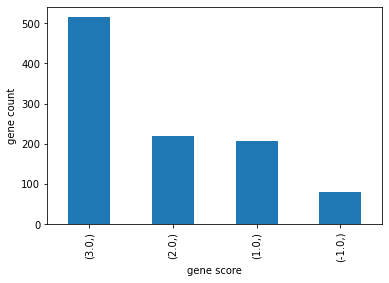

In [8]:
#plot a basic bar-plot
human_gene_score.plot.bar(ylabel='gene count', 
                           xlabel='gene score',
                           legend=False)


## Part 1 - Task 2
Rank the genes by "number-of-reports" and find the top 5 SFARI genes that are in gene-score category.

In [9]:
gene_df_filtered = gene_df[gene_df['gene-score'] == 1] # find all genes with gene score 1

human_report_numbers_sort = gene_df_filtered.sort_values('number-of-reports', ascending = False) # sort rows by number_of_reports in descending order

human_report_numbers_sort.head(5) #show the first 5 lines

,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
596,9,NRXN1,neurexin 1,ENSG00000179915,2,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,0,94
812,9,SHANK3,SH3 and multiple ankyrin repeat domains 3,ENSG00000251322,22,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,1,92
510,9,MECP2,Methyl CpG binding protein 2,ENSG00000169057,X,"Rare Single Gene Mutation, Syndromic, Functional",1.0,1,90
789,9,SCN2A,"sodium channel, voltage-gated, type II, alpha ...",ENSG00000136531,2,"Rare Single Gene Mutation, Syndromic",1.0,0,75
780,9,SCN1A,"sodium channel, voltage-gated, type I, alpha s...",ENSG00000144285,2,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,1,68


## Part 1 - Task 3
For each of these genes find the number of papers in PubMed that include the gene AND are related to Autism.

In [11]:
!pip install biopython

In [22]:
from Bio import Entrez

Entrez.email = "Y.Ben@sms.ed.ac.uk"  # assign email address to Entrez

def get_gene_pub(gene, db_name="pubmed"): 
    # define a function to get publication number related to gene and autism from the given database (default is PubMed)
    handle = Entrez.egquery(term = f"(autism[MH] AND {gene}[sym]") # search query
    # tag [MH] is used to indicate search autism in MeSH subject field for better accuracy
    # tag [sym] is used to indicate gene is a gene-symbol
    record = Entrez.read(handle) # convert handle XML response to dictionary format
    handle.close() # close handle after storing result in record
    for row in record["eGQueryResult"]: # iterate over queryresult
        if row["DbName"]==db_name: # only need the data from the target db_name
            return int(row["Count"]) # return number of papers in integer format (original is string)


gene_list = human_report_numbers_sort.head(5)['gene-symbol'] # get top 5 genes found before

gene_count_dict = {} # create a dict to store results

for gene in gene_list: # iterate over all genes in the list
    gene_count_dict[gene] = get_gene_pub(gene) # use the function defined above to obtain the number of papers in PubMed includes
    
print(gene_count_dict) # print result

{'NRXN1': 52, 'SHANK3': 92, 'MECP2': 112, 'SCN2A': 18, 'SCN1A': 13}


### [Extension A: retrieve the number of papers in pubmed for each gene](#ext_A)

In [ ]:
# this is simply to be done by using the get_gene_pub function
# due to the call frequency limit of Entrez, this block may require a long time to finish

gene_list = gene_df['gene-symbol'] # get all gene symbols

gene_count_dict = {} # create a dict to store results

for gene in gene_list: # iterate over all genes in the list
    gene_count_dict[gene] = get_gene_pub(gene) # use the function defined above to obtain the number of papers in PubMed includes
    
print(gene_count_dict) # print result

## Part 1 - Task 4

From these data fill a table with genes as rows and paper count by year as columns

In [20]:
def get_gene_pub_year(gene, year, db_name="pubmed"): 
    # define a function to get publication number related to gene and autism from the given database (default is PubMed) in the given year
    handle = Entrez.egquery(term = f"(autism[MH] AND {gene}[sym]) AND {year}[DP]") # search query
    # tag [MH] is used to indicate search autism in MeSH subject field for better accuracy
    # tag [sym] is used to indicate gene is a gene-symbol
    # tag [DP] is used to restrict to count papers publised in specific year
    record = Entrez.read(handle) # convert handle XML response to dictionary format
    handle.close() # close handle after storing result in record
    for row in record["eGQueryResult"]: # iterate over queryresult
        if row["DbName"]==db_name: # only need the data from the target db_name
            return int(row["Count"]) # return number of papers in integer format (original is string)


gene_year_dict = {} # create a dict to store result per gene per gene

for gene in human_report_numbers_sort.head(5)['gene-symbol']:
    
    # get year counts of gene in pubmed
    Year_counts = {} # create a dictionary to store number of papers per year
    for i in range(1993,2022,1): # iterate from 1993 to 2021
        Year_counts[i] = get_gene_pub_year(gene, i) # get year publication number related to gene and autism in pubmed
        
    gene_year_dict[gene] = Year_counts # store the whole dictionary into our main output

table_year_paper_df = pd.DataFrame.from_dict(gene_year_dict, orient = "index") # to improve presentation of data, we use pandas to create a table from dict

In [21]:
table_year_paper_df # show table

,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
NRXN1,0,0,0,0,0,0,0,0,0,0,...,5,8,6,4,1,4,3,5,2,2
SHANK3,0,0,0,0,0,0,0,0,0,0,...,6,5,3,5,10,7,11,10,15,4
MECP2,0,0,0,0,0,0,0,2,1,2,...,7,5,7,8,13,7,3,3,6,4
SCN2A,0,0,0,0,0,0,0,0,0,0,...,1,2,1,2,3,0,2,1,1,3
SCN1A,0,0,0,0,0,0,0,0,0,0,...,2,1,0,0,2,0,1,0,2,0


## Part 1 - Task 5
Plot a single stacked histogram displaying the data from the table.

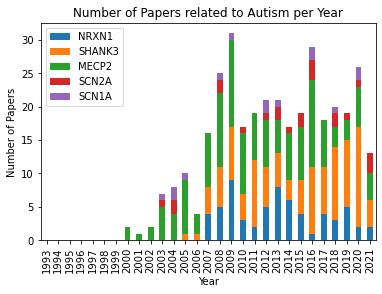

In [50]:
# plot data using Pandas plot.bar method
# T is used to transpose table for better presenting
ax = table_year_paper_df.T.plot.bar(stacked=True, xlabel = "Year", ylabel = "Number of Papers", title = "Number of Papers related to Autism per Year")


### [Extension B: retrieves all citations citing papers related to the given gene with the given link](#ext_B)

In [23]:
def get_all_pub_ids(gene_sym, db_name="pubmed"): # get PubMed IDs related gene-sym and Autism from the given database (default is PubMed)
    handle = Entrez.esearch(term=f"{gene_sym}[sym] AND Autism[MH]",  db=db_name) # create query
    record = Entrez.read(handle) # read XML format response
    handle.close() # close handle after reading data
    
    return record['IdList'] #return idList

def get_all_citations(pub, db_name="pubmed", link_name="pubmed_pubmed_citedin"): #return citation papers cited the input pub in the given database under the given linkname
    handle = Entrez.elink(dbfrom=db_name, id=pub, linkname=link_name) # use elink to retrieve citation papers
    record = Entrez.read(handle)[0] # read XML format response
    handle.close() # close handle after reading data
    
    # return PubIds from the return query
    return {r['DbTo']: [v['Id'] for v in r['Link']] for r in record['LinkSetDb'] if record['LinkSetDb']} 

def get_all_citations_from_gene_sym(gene_sym, db_name="pubmed", link_name="pubmed_pubmed_citedin"): 
    # integrate the above two functions into a single function to get all citations citing papers related to gene-sym and autism in the given database under the given linkname
    all_citation_dict = {} # initialize output dictionary as empty
    pub_ids = get_all_pub_ids(gene_sym, db_name) # get PubIds of papers related to gene-sym in database
    for pub in pub_ids: # iterate over all PubId
        all_citation_dict[pub] = get_all_citations(pub, db_name, link_name) # get all citations citing each pubId and stored them under PubId key
    
    return all_citation_dict #return resutl


# usage example: retrieve all citation data related to NRXN1 in database PubMed
all_citation_dict = get_all_citations_from_gene_sym("NRXN1")

print(all_citation_dict) # print result

{'34487988': {}, '33191396': {'pubmed': ['34680999', '34529206', '33992669', '33957433', '33925709']}, '32472753': {'pubmed': ['32961875']}, '31515794': {}, '31302032': {'pubmed': ['34357104', '34168285', '33842475', '33776808', '33557935', '33308283', '33262688', '33233737', '33191396', '32929080', '32661244', '32487215', '32393347', '32299488', '31811832', '31651061']}, '30988517': {'pubmed': ['34161732', '34021263']}, '30358070': {'pubmed': ['33293697']}, '30190612': {'pubmed': ['34712263', '34657631', '34621295', '34386506', '34208845', '34082144', '33819264', '33776622', '33752146', '33691695', '33681094', '33476483', '33452270', '33407644', '32942984', '32668441', '32640929', '32630718', '32477112', '32359473', '32317787', '32182809', '32152248', '32081867', '32003824', '31957984', '31586494', '31558583', '31491383', '31481879', '31474320', '31461559', '31308794', '31288856', '31231258', '31173071', '31152157', '31134136', '31023718', '30987923', '30842647', '30837845', '30820643

# Part 2

## Part 2 - Task 1
Map the gene-symbol for every gene in the SFARI gene list to an NCBI UID (unique Entrez Gene identifier) 

In [24]:
def get_gene_db_info(gene): # define a function to retrieve gene information from gene database for the given gene
    handle = Entrez.esearch(db='gene', term=f"({gene}[sym] AND Homo Sapiens[Organism])") # querying
    record = Entrez.read(handle) # read XML response
    handle.close() # close handle after reading data
    
    return record['IdList'] # return UID list of genes. Some gene may have more than one UID.


# map all gene-symbol to UID


gene_list = gene_df['gene-symbol'] # get all gene-symbols 

gene_sym_to_id_dict = {} # prepare dictionary to store UID under gene-symbol key

for gene in gene_list: # iterate over all gene
    gene_sym_to_id_dict[gene] = get_gene_db_info(gene) # get gene UIDs
    
print(gene_sym_to_id_dict) #print output
    

{'ABAT': ['18'], 'ABCA10': ['10349'], 'ABCA13': ['154664'], 'ABCA7': ['10347'], 'ACE': ['1636'], 'ACHE': ['43'], 'ACTB': ['60', '728378'], 'ACTL6B': ['51412'], 'ACTN4': ['81'], 'ACY1': ['95'], 'ADA': ['100'], 'ADCY3': ['109', '114'], 'ADCY5': ['111'], 'ADK': ['132'], 'ADNP': ['23394'], 'ADORA3': ['140'], 'ADSL': ['158'], 'AFF2': ['2334'], 'AGAP1': ['116987'], 'AGAP2': ['116986'], 'ADSS2': ['159'], 'AGBL4': ['84871'], 'AGMO': ['392636'], 'AGO1': ['26523'], 'AGO3': ['192669', '79910'], 'AGO4': ['192670', '54791'], 'AGTR2': ['186'], 'AHDC1': ['27245'], 'AHI1': ['54806'], 'AKAP9': ['10142'], 'ALDH1A3': ['220'], 'ALDH5A1': ['7915'], 'AMPD1': ['270'], 'AMT': ['275'], 'ANK2': ['287'], 'ANK3': ['288'], 'ANKRD11': ['29123'], 'AGAP5': ['729092'], 'AGO2': ['27161'], 'AHNAK': ['79026', '195'], 'ANKRD17': ['26057'], 'ANKS1B': ['56899'], 'ANXA1': ['301'], 'AP1S2': ['8905'], 'APBA2': ['321'], 'APBB1': ['322'], 'APH1A': ['51107'], 'ARHGAP11B': ['89839', '449618'], 'ARHGAP32': ['9743'], 'ARHGAP5': ['39

In [26]:
# prepare a dataframe having two columns gene_sym and gene_id
# such that each row represents a pair of gene-symbol and gene-id
# because some gene-symbol have more than 1 gene-id
# it's necessary to construct two new lists for gene-ids and gene-syms 

geneid_list = [] 
genesym_list = []
for genesym in gene_sym_to_id_dict: # iterate over all sym 
    id_list = gene_sym_to_id_dict[genesym] # get gene id list
    geneid_list += [int(i) for i in id_list] # concat gene id list with the full id list
    genesym_list += [genesym] * len(id_list) # cancat gene sym list with the full sym list

geneid_df = pd.DataFrame(zip(genesym_list, geneid_list),columns = ["gene_sym", "gene_id"]) # create a dataframe from these two lists

In [27]:
geneid_df # view table

,gene_sym,gene_id
0,ABAT,18
1,ABCA10,10349
2,ABCA13,154664
3,ABCA7,10347
4,ACE,1636
...,...,...
1191,ZMYM2,7750
1192,ZMYND8,23613
1193,ZNF827,152485
1194,ZSWIM6,57688


## Part 2 - Task 2
Using the gene2go file from NCBI that we worked with in week 8 find the Gene Ontology terms that have been annotated to all of the SFARI genes

In [25]:
# uncommend the line below if gene2go.gz is not stored locally
# ul.request.urlretrieve('https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz','gene2go.gz') # retrieve data from NCBI


gene2go = pd.read_csv('gene2go.gz', compression='gzip', header=0, sep='\t') # read data into dataframe

gene2go.head() # view first few rows of the table 

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
0,3702,814629,GO:0005634,ISM,located_in,nucleus,-,Component
1,3702,814629,GO:0008150,ND,involved_in,biological_process,-,Process
2,3702,814630,GO:0003700,ISS,enables,DNA-binding transcription factor activity,11118137,Function
3,3702,814630,GO:0005634,ISM,located_in,nucleus,-,Component
4,3702,814630,GO:0006355,TAS,acts_upstream_of_or_within,"regulation of transcription, DNA-templated",11118137,Process


In [37]:
# merge two dataframes into a single one with both gene_symbol and gene_id information paired

merge_df = pd.merge(geneid_df, gene2go, left_on = "gene_id", right_on = "GeneID")
# merged dataframe only contain rows with gene_id appears both in geneid_df and gene2go
# in other words, merged dataframe has exactly these GO-terms annotated to at least one of the SFARI gene.

In [38]:
merge_df # view merged dataframe

,gene_sym,gene_id,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
0,ABAT,18,9606,18,GO:0001666,IEA,involved_in,response to hypoxia,-,Process
1,ABAT,18,9606,18,GO:0003867,IDA,contributes_to,4-aminobutyrate transaminase activity,15528998,Function
2,ABAT,18,9606,18,GO:0005739,IBA,is_active_in,mitochondrion,21873635,Component
3,ABAT,18,9606,18,GO:0005739,IDA,located_in,mitochondrion,-,Component
4,ABAT,18,9606,18,GO:0005739,ISS,located_in,mitochondrion,-,Component
...,...,...,...,...,...,...,...,...,...,...
29307,ZWILCH,55055,9606,55055,GO:0034501,IMP,involved_in,protein localization to kinetochore,15824131,Process
29308,ZWILCH,55055,9606,55055,GO:0051301,IEA,involved_in,cell division,-,Process
29309,ZWILCH,55055,9606,55055,GO:1990423,IBA,part_of,RZZ complex,21873635,Component
29310,ZWILCH,55055,9606,55055,GO:1990423,IDA,part_of,RZZ complex,20462495,Component


## Part 2 - Task 3
Now split the genes up into three lists by their SFARI gene-score.

In [30]:
# merge gene_df to add gene_score information into the merge_df

merge_gene_score_df = pd.merge(merge_df, gene_df, left_on = "gene_sym", right_on = "gene-symbol")

In [31]:
merge_gene_score_df # view table

,gene_sym,gene_id,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
0,ABAT,18,9606,18,GO:0001666,IEA,involved_in,response to hypoxia,-,Process,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
1,ABAT,18,9606,18,GO:0003867,IDA,contributes_to,4-aminobutyrate transaminase activity,15528998,Function,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
2,ABAT,18,9606,18,GO:0005739,IBA,is_active_in,mitochondrion,21873635,Component,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
3,ABAT,18,9606,18,GO:0005739,IDA,located_in,mitochondrion,-,Component,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
4,ABAT,18,9606,18,GO:0005739,ISS,located_in,mitochondrion,-,Component,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29307,ZWILCH,55055,9606,55055,GO:0034501,IMP,involved_in,protein localization to kinetochore,15824131,Process,9,ZWILCH,zwilchkinetochore protein,ENSG00000174442,15,Rare Single Gene Mutation,3.0,0,4
29308,ZWILCH,55055,9606,55055,GO:0051301,IEA,involved_in,cell division,-,Process,9,ZWILCH,zwilchkinetochore protein,ENSG00000174442,15,Rare Single Gene Mutation,3.0,0,4
29309,ZWILCH,55055,9606,55055,GO:1990423,IBA,part_of,RZZ complex,21873635,Component,9,ZWILCH,zwilchkinetochore protein,ENSG00000174442,15,Rare Single Gene Mutation,3.0,0,4
29310,ZWILCH,55055,9606,55055,GO:1990423,IDA,part_of,RZZ complex,20462495,Component,9,ZWILCH,zwilchkinetochore protein,ENSG00000174442,15,Rare Single Gene Mutation,3.0,0,4


In [40]:
gene_score1 = merge_gene_score_df[merge_gene_score_df['gene-score'] ==1] # filter table by keeping all rows with gene-score 1
gene_score2 = merge_gene_score_df[merge_gene_score_df['gene-score'] ==2] # filter table by keeping all rows with gene-score 2
gene_score3 = merge_gene_score_df[merge_gene_score_df['gene-score'] ==3] # filter table by keeping all rows with gene-score 3

In [41]:
gene_score1 # table of genes with gene score 1

,gene_sym,gene_id,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
265,ACTB,60,9606,60,GO:0000079,ISS,involved_in,regulation of cyclin-dependent protein serine/...,-,Process,9,ACTB,actin beta,ENSG00000075624,7,"Rare Single Gene Mutation, Syndromic",1.0,1,5
266,ACTB,60,9606,60,GO:0000785,HDA,located_in,chromatin,16217013,Component,9,ACTB,actin beta,ENSG00000075624,7,"Rare Single Gene Mutation, Syndromic",1.0,1,5
267,ACTB,60,9606,60,GO:0000786,IDA,part_of,nucleosome,27153538,Component,9,ACTB,actin beta,ENSG00000075624,7,"Rare Single Gene Mutation, Syndromic",1.0,1,5
268,ACTB,60,9606,60,GO:0001738,IMP,involved_in,morphogenesis of a polarized epithelium,22855531,Process,9,ACTB,actin beta,ENSG00000075624,7,"Rare Single Gene Mutation, Syndromic",1.0,1,5
269,ACTB,60,9606,60,GO:0001895,HEP,involved_in,retina homeostasis,23580065,Process,9,ACTB,actin beta,ENSG00000075624,7,"Rare Single Gene Mutation, Syndromic",1.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29278,ZMYND8,23613,9606,23613,GO:0030336,IMP,involved_in,negative regulation of cell migration,27477906,Process,9,ZMYND8,zinc finger MYND-type containing 8,ENSG00000101040,20,Rare Single Gene Mutation,1.0,0,4
29279,ZMYND8,23613,9606,23613,GO:0035064,IDA,enables,methylated histone binding,27477906,Function,9,ZMYND8,zinc finger MYND-type containing 8,ENSG00000101040,20,Rare Single Gene Mutation,1.0,0,4
29280,ZMYND8,23613,9606,23613,GO:0045892,IEA,involved_in,"negative regulation of transcription, DNA-temp...",-,Process,9,ZMYND8,zinc finger MYND-type containing 8,ENSG00000101040,20,Rare Single Gene Mutation,1.0,0,4
29281,ZMYND8,23613,9606,23613,GO:0070577,IDA,enables,lysine-acetylated histone binding,27477906,Function,9,ZMYND8,zinc finger MYND-type containing 8,ENSG00000101040,20,Rare Single Gene Mutation,1.0,0,4


In [42]:
gene_score2 # table of genes with gene score 2

,gene_sym,gene_id,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
220,ACHE,43,9606,43,GO:0001507,NAS,involved_in,acetylcholine catabolic process in synaptic cleft,1517212,Process,9,ACHE,Acetylcholinesterase (Yt blood group),ENSG00000087085,7,Rare Single Gene Mutation,2.0,0,5
221,ACHE,43,9606,43,GO:0001540,TAS,enables,amyloid-beta binding,11283752,Function,9,ACHE,Acetylcholinesterase (Yt blood group),ENSG00000087085,7,Rare Single Gene Mutation,2.0,0,5
222,ACHE,43,9606,43,GO:0001919,IEA,involved_in,regulation of receptor recycling,-,Process,9,ACHE,Acetylcholinesterase (Yt blood group),ENSG00000087085,7,Rare Single Gene Mutation,2.0,0,5
223,ACHE,43,9606,43,GO:0002076,IEP,involved_in,osteoblast development,15454088,Process,9,ACHE,Acetylcholinesterase (Yt blood group),ENSG00000087085,7,Rare Single Gene Mutation,2.0,0,5
224,ACHE,43,9606,43,GO:0003990,IBA,enables,acetylcholinesterase activity,21873635,Function,9,ACHE,Acetylcholinesterase (Yt blood group),ENSG00000087085,7,Rare Single Gene Mutation,2.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29263,ZMYM2,7750,9606,7750,GO:0005829,TAS,located_in,cytosol,-,Component,9,ZMYM2,zinc finger MYM-type containing 2,ENSG00000121741,13,"Rare Single Gene Mutation, Syndromic",2.0,1,6
29264,ZMYM2,7750,9606,7750,GO:0008150,ND,involved_in,biological_process,-,Process,9,ZMYM2,zinc finger MYM-type containing 2,ENSG00000121741,13,"Rare Single Gene Mutation, Syndromic",2.0,1,6
29265,ZMYM2,7750,9606,7750,GO:0008270,NAS,enables,zinc ion binding,9576949,Function,9,ZMYM2,zinc finger MYM-type containing 2,ENSG00000121741,13,"Rare Single Gene Mutation, Syndromic",2.0,1,6
29266,ZMYM2,7750,9606,7750,GO:0016605,IDA,located_in,PML body,17027752,Component,9,ZMYM2,zinc finger MYM-type containing 2,ENSG00000121741,13,"Rare Single Gene Mutation, Syndromic",2.0,1,6


In [43]:
gene_score3 # table of genes with gene score 3

,gene_sym,gene_id,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
0,ABAT,18,9606,18,GO:0001666,IEA,involved_in,response to hypoxia,-,Process,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
1,ABAT,18,9606,18,GO:0003867,IDA,contributes_to,4-aminobutyrate transaminase activity,15528998,Function,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
2,ABAT,18,9606,18,GO:0005739,IBA,is_active_in,mitochondrion,21873635,Component,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
3,ABAT,18,9606,18,GO:0005739,IDA,located_in,mitochondrion,-,Component,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
4,ABAT,18,9606,18,GO:0005739,ISS,located_in,mitochondrion,-,Component,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29307,ZWILCH,55055,9606,55055,GO:0034501,IMP,involved_in,protein localization to kinetochore,15824131,Process,9,ZWILCH,zwilchkinetochore protein,ENSG00000174442,15,Rare Single Gene Mutation,3.0,0,4
29308,ZWILCH,55055,9606,55055,GO:0051301,IEA,involved_in,cell division,-,Process,9,ZWILCH,zwilchkinetochore protein,ENSG00000174442,15,Rare Single Gene Mutation,3.0,0,4
29309,ZWILCH,55055,9606,55055,GO:1990423,IBA,part_of,RZZ complex,21873635,Component,9,ZWILCH,zwilchkinetochore protein,ENSG00000174442,15,Rare Single Gene Mutation,3.0,0,4
29310,ZWILCH,55055,9606,55055,GO:1990423,IDA,part_of,RZZ complex,20462495,Component,9,ZWILCH,zwilchkinetochore protein,ENSG00000174442,15,Rare Single Gene Mutation,3.0,0,4


## Part 2 - Task 4

Create tables of the 10 most commonly annotated terms for each gene list. The tables should have the following columns: GO term ID, GO term Description, GO term count.

In [44]:
# group rows by the key of the pair GO term ID and GO term description and count the number of records in each group
# each GO term ID has a unique GO term description and thus although the group key has two elements
# it is the same as grouping by GO term ID only. The reason why using two elements here is to keep these two column in
# the result series.

table_gene_score1 = gene_score1.groupby(['GO_ID', 'GO_term']).size()

# sort series by the group size
table_gene_score1 = table_gene_score1.sort_values(ascending=False)

# reformat series obtained above into dataframe and define the new column as count
table_top_score1 = pd.DataFrame(table_gene_score1, columns = ["count"])

# reset index to make GO term ID and Go term Description as two columns instead of row index
# retrieve the top 10 most annotated GO term 
table_top_score1.reset_index().head(10)

,GO_ID,GO_term,count
0,GO:0005515,protein binding,173
1,GO:0005634,nucleus,164
2,GO:0005654,nucleoplasm,141
3,GO:0005886,plasma membrane,103
4,GO:0005829,cytosol,102
5,GO:0005737,cytoplasm,81
6,GO:0045944,positive regulation of transcription by RNA po...,70
7,GO:0000981,"DNA-binding transcription factor activity, RNA...",53
8,GO:0000122,negative regulation of transcription by RNA po...,50
9,GO:0006357,regulation of transcription by RNA polymerase II,49


In [45]:
# group rows by the key of the pair GO term ID and GO term description and count the number of records in each group
# each GO term ID has a unique GO term description and thus although the group key has two elements
# it is the same as grouping by GO term ID only. The reason why using two elements here is to keep these two column in
# the result series.
table_gene_score2 = gene_score2.groupby(['GO_ID', 'GO_term']).size()

# sort series by the group size
table_gene_score2 = table_gene_score2.sort_values(ascending=False)

# reformat series obtained above into dataframe and define the new column as count
table_top_score2 = pd.DataFrame(table_gene_score2, columns = ["count"])

# reset index to make GO term ID and Go term Description as two columns instead of row index
# retrieve the top 10 most annotated GO term 
table_top_score2.reset_index().head(10)

,GO_ID,GO_term,count
0,GO:0005515,protein binding,162
1,GO:0005886,plasma membrane,142
2,GO:0005634,nucleus,128
3,GO:0005829,cytosol,111
4,GO:0005654,nucleoplasm,103
5,GO:0005737,cytoplasm,93
6,GO:0003723,RNA binding,49
7,GO:0016020,membrane,43
8,GO:0005887,integral component of plasma membrane,40
9,GO:0070062,extracellular exosome,34


In [46]:
# group rows by the key of the pair GO term ID and GO term description and count the number of records in each group
# each GO term ID has a unique GO term description and thus although the group key has two elements
# it is the same as grouping by GO term ID only. The reason why using two elements here is to keep these two column in
# the result series.
table_gene_score3 = gene_score3.groupby(['GO_ID', 'GO_term']).size()

# sort series by the group size
table_gene_score3 = table_gene_score3.sort_values(ascending=False)

# reformat series obtained above into dataframe and define the new column as count
table_top_score3 = pd.DataFrame(table_gene_score3, columns = ["count"])

# reset index to make GO term ID and Go term Description as two columns instead of row index
# retrieve the top 10 most annotated GO term 
table_top_score3.reset_index().head(10)

,GO_ID,GO_term,count
0,GO:0005515,protein binding,370
1,GO:0005886,plasma membrane,290
2,GO:0005829,cytosol,234
3,GO:0005634,nucleus,204
4,GO:0005737,cytoplasm,175
5,GO:0005654,nucleoplasm,163
6,GO:0005887,integral component of plasma membrane,102
7,GO:0016021,integral component of membrane,96
8,GO:0016020,membrane,80
9,GO:0046872,metal ion binding,73


## Part 2 - Task 5

Take the three lists of UIDs created above and use the PantherDB tool - http://pantherdb.org/ to perform a “Functional classification viewed in graphic charts” analysis reporting and select the “Bar chart” display option, using default settings. Once on the results page displaying the bar chart use the pull-down menu to change the ontology to “Biological Process”. Click the small (!) “export” button to download the results as a text file and us this to make your own bar chart

In [180]:
# read exported txt files from pantherDB for each of 3 gene scores.

# gene score 1
chart_score1 = pd.read_csv('pantherChart_score1.txt', header=None, sep = "\t") # read txt
chart_score1.columns=['row_index', 'category', '#genes', '#genes/(total # genes)', '#genes/(total # process hits)'] # rename columns

# gene score 2
chart_score2 = pd.read_csv('pantherChart_score2.txt', header=None, sep = "\t") # read txt
chart_score2.columns=['row_index', 'category', '#genes', '#genes/(total # genes)', '#genes/(total # process hits)'] # rename columns

# gene score 3
chart_score3 = pd.read_csv('pantherChart_score3.txt', header=None, sep = "\t") # read txt
chart_score3.columns=['row_index', 'category', '#genes', '#genes/(total # genes)', '#genes/(total # process hits)'] # rename columns

<AxesSubplot:title={'center':'Panther GO-slim biological process\n Total # Genes: 677 Total # Process hit: 1431'}, xlabel='category', ylabel='Genes'>

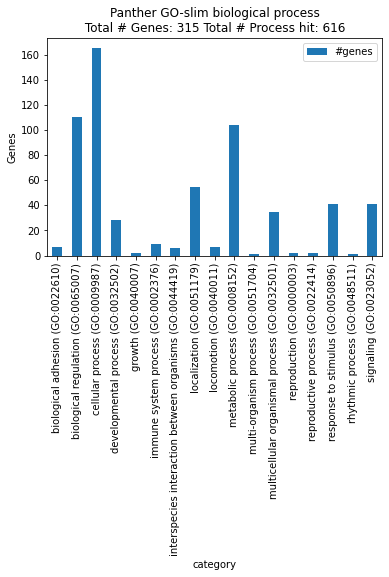

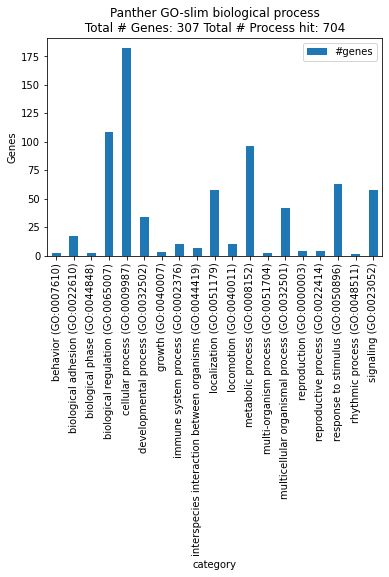

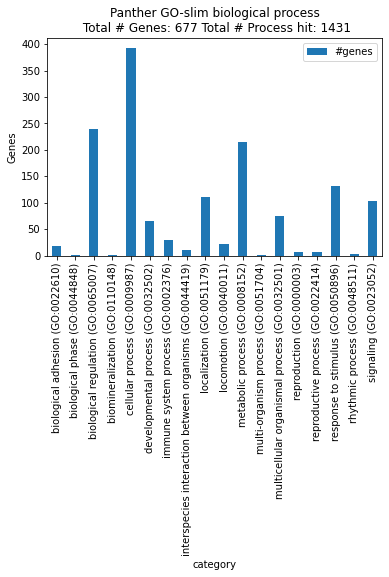

In [185]:
# plot the Panther GO-slim biological process for each gene-score table
# table are sorted by category alphabetic order to mimic the presentation style of Panther Bar Chart on the website

# plot gene score 1
chart_score1.set_index('category')[['#genes']].sort_index().plot.bar(ylabel="Genes", title="Panther GO-slim biological process\n Total # Genes: 315 Total # Process hit: 616 ")

# plot gene score 2
chart_score2.set_index('category')[['#genes']].sort_index().plot.bar(ylabel="Genes", title="Panther GO-slim biological process\n Total # Genes: 307 Total # Process hit: 704 ")

# plot gene score 3
chart_score3.set_index('category')[['#genes']].sort_index().plot.bar(ylabel="Genes", title="Panther GO-slim biological process\n Total # Genes: 677 Total # Process hit: 1431")

### [Extension C: Statistical Analysis on top 10 most annotated GO terms](#ext_C)

In [83]:
# this extension is illustrated through gene-score 1 category but can be easily transferred to all other categories

# retrieve the full information table by inner merging
# only GO_ID appears in table_top_score1 will be kept 
# because all GO_IDs in table_top_score1 are also in gene_score1 which is the full table of all genes in gene score 1 category
top_anno_full_df = pd.merge(gene_score1, table_top_score1, left_on=['GO_ID'], right_on=['GO_ID'])
top_anno_full_df # view table

,gene_sym,gene_id,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports,count
0,ACTB,60,9606,60,GO:0000079,ISS,involved_in,regulation of cyclin-dependent protein serine/...,-,Process,9,ACTB,actin beta,ENSG00000075624,7,"Rare Single Gene Mutation, Syndromic",1.0,1,5,1
1,ACTB,60,9606,60,GO:0000785,HDA,located_in,chromatin,16217013,Component,9,ACTB,actin beta,ENSG00000075624,7,"Rare Single Gene Mutation, Syndromic",1.0,1,5,41
2,ADNP,23394,9606,23394,GO:0000785,ISA,located_in,chromatin,-,Component,9,ADNP,Activity-dependent neuroprotector homeobox,ENSG00000101126,20,"Rare Single Gene Mutation, Syndromic",1.0,1,52,41
3,ARX,170302,9606,170302,GO:0000785,ISA,located_in,chromatin,-,Component,9,ARX,aristaless related homeobox,ENSG00000004848,X,"Rare Single Gene Mutation, Syndromic",1.0,1,19,41
4,CASZ1,54897,9606,54897,GO:0000785,IDA,located_in,chromatin,27693370,Component,9,CASZ1,castor zinc finger 1,ENSG00000130940,1,Rare Single Gene Mutation,1.0,0,5,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6872,UBR1,197131,9606,197131,GO:0071233,IDA,involved_in,cellular response to leucine,20298436,Process,9,UBR1,ubiquitin protein ligase E3 component n-recogn...,ENSG00000159459,15,Rare Single Gene Mutation,1.0,0,1,1
6873,UBR1,197131,9606,197131,GO:0071596,IBA,involved_in,ubiquitin-dependent protein catabolic process ...,21873635,Process,9,UBR1,ubiquitin protein ligase E3 component n-recogn...,ENSG00000159459,15,Rare Single Gene Mutation,1.0,0,1,1
6874,ZBTB20,26137,9606,26137,GO:0045821,ISS,involved_in,positive regulation of glycolytic process,-,Process,9,ZBTB20,Zinc finger and BTB domain containing 20,ENSG00000181722,3,"Rare Single Gene Mutation, Syndromic",1.0,1,25,1
6875,ZBTB20,26137,9606,26137,GO:0046889,ISS,involved_in,positive regulation of lipid biosynthetic process,-,Process,9,ZBTB20,Zinc finger and BTB domain containing 20,ENSG00000181722,3,"Rare Single Gene Mutation, Syndromic",1.0,1,25,1


In [84]:
# Get genes frequency series of appearing in these GO-IDs

# groupby gene symbol and sort in descending order
gene_stat = top_anno_full_df.groupby('gene_sym').size().sort_values(ascending=False)

gene_stat # view

gene_sym
CTNNB1      225
PTEN        139
FMR1        125
HNRNPU      124
MEF2C       118
           ... 
MED13L        3
PRR12         3
AHDC1         2
VPS13B        1
KIAA0232      1
Length: 207, dtype: int64

### [Extension D: KEGG module in BioPython](#ext_D)

In [77]:
!pip install ReportLab

# Import Biopython modules to interact with KEGG
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

from IPython.display import Image


# Print information about the PATHWAY database
result = REST.kegg_info("pathway").read()
print(result)

pathway          KEGG Pathway Database
path             Release 100.0+/11-29, Nov 21
                 Kanehisa Laboratories
                 849,550 entries

linked db        module
                 ko
                 genome
                 <org>
                 compound
                 glycan
                 reaction
                 rclass
                 enzyme
                 network
                 disease
                 drug
                 pubmed



In [62]:
# get NRXN1 KEGG ID 
result = REST.kegg_find('genes', 'NRXN1').read()
print(result)

hsa:9378	NRXN1, Hs.22998, PTHSL2, SCZD17; neurexin 1
ptr:459224	NRXN1; neurexin-1 isoform X27
pps:100991762	NRXN1; neurexin 1
ggo:101126227	NRXN1; neurexin-1 isoform X29
pon:100454997	NRXN1; neurexin-1 isoform X13
nle:100584472	NRXN1; neurexin-1 isoform X1
mcc:619185	NRXN1; neurexin-1 isoform X15
mcf:102127141	NRXN1; neurexin 1
csab:103220287	NRXN1; neurexin 1
caty:105590628	NRXN1; neurexin-1-beta isoform X1
panu:101013517	NRXN1; neurexin-1 isoform X33
rro:115894161	NRXN1; neurexin-1 isoform X1
tfn:117062318	NRXN1; neurexin-1 isoform X1
pteh:111550439	NRXN1; neurexin-1 isoform X1
cjc:100410393	NRXN1; neurexin 1
sbq:101033435	NRXN1; neurexin-1-beta isoform X6
mmur:105867822	NRXN1; neurexin-1 isoform X2
mmu:18189	Nrxn1, 1700062G21Rik, 9330127H16Rik, A230068P09Rik, mKIAA0578; neurexin I
mcal:110284084	Nrxn1; neurexin-1 isoform X1
mpah:110335619	Nrxn1; neurexin-1 isoform X1
rno:60391	Nrxn1; neurexin-1 precursor
mcoc:116080246	Nrxn1; neurexin-1 isoform X1
cge:100761660	Nrxn1; neurexin-1 iso

In [75]:
# Search all information related to hsa:9378
result = REST.kegg_get('hsa:9378').read()
print(result)

ENTRY       9378              CDS       T01001
SYMBOL      NRXN1, Hs.22998, PTHSL2, SCZD17
NAME        (RefSeq) neurexin 1
ORTHOLOGY   K07377  neurexin
ORGANISM    hsa  Homo sapiens (human)
PATHWAY     hsa04514  Cell adhesion molecules
DISEASE     H00756  Pitt-Hopkins syndrome
BRITE       KEGG Orthology (KO) [BR:hsa00001]
             09130 Environmental Information Processing
              09133 Signaling molecules and interaction
               04514 Cell adhesion molecules
                9378 (NRXN1)
             09180 Brite Hierarchies
              09182 Protein families: genetic information processing
               04131 Membrane trafficking [BR:hsa04131]
                9378 (NRXN1)
            Membrane trafficking [BR:hsa04131]
             Exocytosis
              Calcium ion-dependent exocytosis
               Others
                9378 (NRXN1)
POSITION    2p16.3
MOTIF       Pfam: Laminin_G_2 Laminin_G_1 Syndecan Laminin_G_3 DUF202 CD34_antigen
DBLINKS     NCBI-GeneID: 937

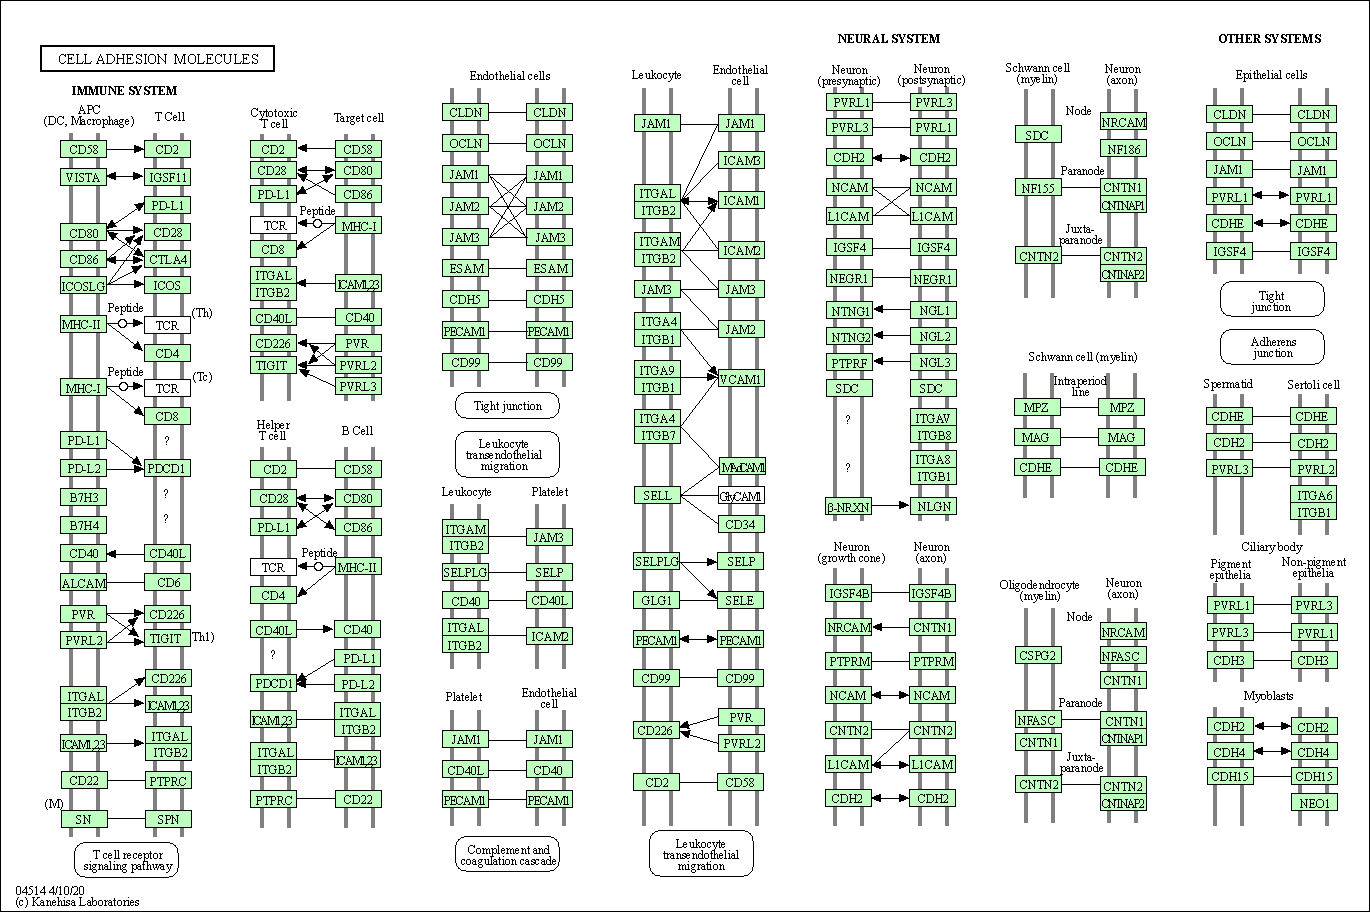

In [78]:
# visualize pathway 
result = REST.kegg_get("hsa04514", "image").read()
Image(result)

# Part 3

## Part 3 - Task 1
Create a plain text file of the NCBI UIDs for all of the gene-score 1 SFARI genes. Then, using the STRING website (https://string-db.org/) upload the gene-score 1 gene list, select “homo sapiens” as the species and hit search then click continue to visualise the protein-protein interaction network. In this network the genes are the nodes and the interactions between them the edges (connections). Click the “analysis” option near the bottom and report the following statistics: “number of nodes”, “number of edges” and “average node degree”

In [190]:
UID_score1=list(set(gene_score1["gene_id"])) # get unique UID in gene score 1 category

In [87]:
def save_as_txt(doc, file_name):  # create a helper function to store a list into a txt file
    textfile = open(file_name, "w") # open file with the given name
    for element in doc: # iterate over element in document
        textfile.write(str(element) + "\n") # write element into txt file
    textfile.close() # close file handler

In [194]:
save_as_txt(UID_score1,"score1_UID.txt") # save these UIDs into a txt file by the helper function save_as_txt

## Part 3 - Task 2
Click the “cluster” option and select “MCL clustering” with the default option. Download the “MCL clusters in TSV format” file. From this, find the two biggest clusters produced by the MCL clustering and use the PantherDB tool as in Part Two to analyse the function of genes in these clusters. This time instead of selecting “Biological Process” ontology use the “Pathway” ontology 

In [47]:
MCL_df = pd.read_csv('string_MCL_clusters.tsv',sep='\t') # read MCL cluster tsv file into dataframe

In [48]:
MCL_df # view table

,#clustering method,cluster number,cluster color,gene count,protein name,protein identifier,protein description
0,MCL,1,Red,32,ADSL,9606.ENSP00000485525,Adenylosuccinate lyase; Catalyzes two non-sequ...
1,MCL,1,Red,32,ARX,9606.ENSP00000368332,Homeobox protein ARX; Transcription factor req...
2,MCL,1,Red,32,BRSK2,9606.ENSP00000371614,Serine/threonine-protein kinase BRSK2; Serine/...
3,MCL,1,Red,32,CASK,9606.ENSP00000367408,Peripheral plasma membrane protein CASK; Multi...
4,MCL,1,Red,32,DLG4,9606.ENSP00000382428,Disks large homolog 4; Interacts with the cyto...
...,...,...,...,...,...,...,...
200,MCL,44,Pink,1,DYNC1H1,9606.ENSP00000348965,Cytoplasmic dynein 1 heavy chain 1; Cytoplasmi...
201,MCL,45,Hot Pink 2,1,KDM5C,9606.ENSP00000364550,Lysine-specific demethylase 5C; Histone demeth...
202,MCL,46,Pale Violet Red,1,ZMYND8,9606.ENSP00000420095,Protein kinase C-binding protein 1; May act as...
203,MCL,47,Light Coral 2,1,GIGYF2,9606.ENSP00000387170,GRB10-interacting GYF protein 2; Key component...


In [49]:
# From the table view above, cluster number is ordered in a way that smaller cluster has larger size
# Therefore, to obtain the largest cluster, we filter on the condition cluster_number == 1

cluster_1 = MCL_df[MCL_df["cluster number"]==1] 

In [50]:
cluster_1_dict = {} # create an empty dictionary

for gene in cluster_1['protein name']: # iterate over gene in cluster_1
    cluster_1_dict[gene] = get_gene_db_info(gene) # use the function defined in part 2 to obtain UID from gene-symbol

print(cluster_1_dict) # view result

{'ADSL': ['158'], 'ARX': ['170302', '10054', '170640'], 'BRSK2': ['9024'], 'CASK': ['8573'], 'DLG4': ['1742', '3996'], 'DPYSL2': ['1808'], 'DSCAM': ['1826'], 'ELAVL3': ['1995'], 'GABRB3': ['2562'], 'GFAP': ['2670'], 'GRIN2B': ['2904'], 'IQSEC2': ['23096'], 'LLGL1': ['3996'], 'LRRC4C': ['57689'], 'MAP1A': ['4130', '23173'], 'NBEA': ['26960'], 'NLGN2': ['57555'], 'NLGN3': ['54413'], 'NLGN4X': ['57502'], 'NRXN1': ['9378'], 'NRXN2': ['9379'], 'NRXN3': ['9369'], 'PTCHD1': ['139411'], 'RELN': ['5649'], 'RIMS1': ['22999'], 'SHANK2': ['22941', '170817'], 'SLC6A1': ['6529'], 'STXBP1': ['6812'], 'SYN1': ['6853', '9623'], 'SYNGAP1': ['8831'], 'TANC2': ['26115'], 'TRIO': ['7204']}


In [51]:
# To obtain the second largest cluster, we filter on the condition cluster_number == 2

cluster_2 = MCL_df[MCL_df["cluster number"]==2]

In [52]:
cluster_2_dict = {} # create an empty dictionary

for gene in cluster_2['protein name']: # iterate over gene in cluster_2
    cluster_2_dict[gene] = get_gene_db_info(gene) # use the function defined in part 2 to obtain UID from gene-symbol
    
print(cluster_2_dict) # view result

{'ARID1B': ['57492'], 'ASXL3': ['80816'], 'ATRX': ['546'], 'BAZ2B': ['29994'], 'BCL11A': ['53335'], 'CHD3': ['1107'], 'CHD7': ['55636', '338420'], 'CREBBP': ['1387'], 'CTCF': ['10664'], 'DNMT3A': ['1788'], 'EP300': ['2033'], 'HDLBP': ['3069'], 'KMT2A': ['4297'], 'KMT2C': ['58508'], 'LDB1': ['8861', '9079'], 'LDB2': ['9079'], 'MED13': ['9969'], 'MED13L': ['23389'], 'PAX5': ['5079'], 'SATB1': ['6304'], 'SETBP1': ['26040'], 'SMARCA2': ['6595'], 'SMARCA4': ['6597'], 'SMARCC2': ['6601'], 'SRCAP': ['10847']}


In [53]:
def get_all_UID(cluster_dict):
    # create a function to retrieve all UIDs from cluster_dict
    # these UIDs are used for PantherDB website
    UID_list = [] # initialize empty list
    
    for geneid_list in cluster_dict.values(): # iterate over all UID lists in cluster_dict
        UID_list += [int(i) for i in geneid_list] # concate UID list to the full UID list
    
    return UID_list

In [54]:
cluster_1_list = get_all_UID(cluster_1_dict) # get UID list in cluster 1

print(cluster_1_list) # view result

[158, 170302, 10054, 170640, 9024, 8573, 1742, 3996, 1808, 1826, 1995, 2562, 2670, 2904, 23096, 3996, 57689, 4130, 23173, 26960, 57555, 54413, 57502, 9378, 9379, 9369, 139411, 5649, 22999, 22941, 170817, 6529, 6812, 6853, 9623, 8831, 26115, 7204]


In [55]:
cluster_2_list = get_all_UID(cluster_2_dict) # get UID list in cluster 2

print(cluster_2_list) # view result

[57492, 80816, 546, 29994, 53335, 1107, 55636, 338420, 1387, 10664, 1788, 2033, 3069, 4297, 58508, 8861, 9079, 9079, 9969, 23389, 5079, 6304, 26040, 6595, 6597, 6601, 10847]


In [220]:
# read exported Pathway txt files for two clusters from PantherDB

chart_cluster1 = pd.read_csv('pantherChart_cluster_1.txt', header=None, sep = "\t") # read txt file for cluster 1
chart_cluster1.columns=['row_index', 'category', '#genes', '#genes/(total # genes)', '#genes/(total # process hits)'] # rename columns

chart_cluster2 = pd.read_csv('pantherChart_cluster_2.txt', header=None, sep = "\t") # read txt file for cluster 2
chart_cluster2.columns=['row_index', 'category', '#genes', '#genes/(total # genes)', '#genes/(total # process hits)'] # rename columns


<AxesSubplot:title={'center':'Panther Pathway\n Total # Genes: 37 Total # Process hit: 16 '}, xlabel='category', ylabel='Genes'>

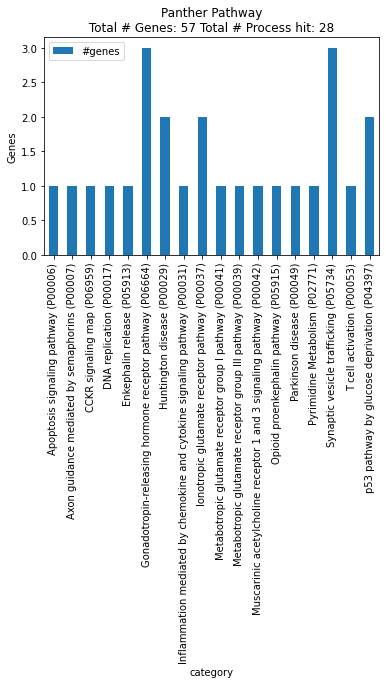

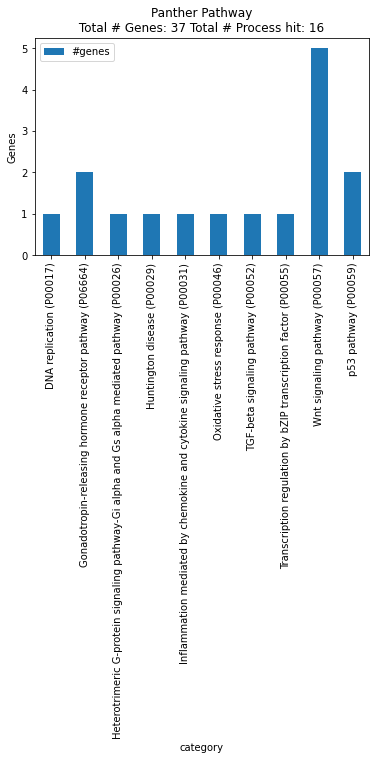

In [222]:
# plot Panther Pathway bar chart for each cluster
# both tables are sorted by category alphabetic order to mimic the presentaiton of bar chart on PantherDB website

chart_cluster1.set_index('category')[['#genes']].sort_index().plot.bar(ylabel="Genes", title="Panther Pathway\n Total # Genes: 57 Total # Process hit: 28 ")
chart_cluster2.set_index('category')[['#genes']].sort_index().plot.bar(ylabel="Genes", title="Panther Pathway\n Total # Genes: 37 Total # Process hit: 16 ")


## Part 3 - Task 3
Click the “exports” option and download the network as a “bitmap image” file [ Not in this jupyter notebook, please refer to the report ]

### [Extension E: cluster analysis applied to gene-score 2 and even more](#ext_E)

Two utility functions are provided to simplify the analyze procedure. These functions are highly abstract and thus can be applied to any restricted gene lists without hassles.

In [93]:
UID_score2=list(set(gene_score2["gene_id"])) # get unique UID in gene score 1 category

save_as_txt(UID_score2, 'UID_score2.txt') # save UID into a txt file

In [89]:
# read MCL cluster file exported from SpringDB
MCL_2_df = pd.read_csv('gene_score_2_MCL.tsv',sep='\t') # read MCL cluster tsv file into dataframe
MCL_2_df # view

,#clustering method,cluster number,cluster color,gene count,protein name,protein identifier,protein description
0,MCL,1,Red,13,ATP2B2,9606.ENSP00000353414,Plasma membrane calcium-transporting ATPase 2;...
1,MCL,1,Red,13,DLGAP1,9606.ENSP00000316377,Disks large-associated protein 1; Part of the ...
2,MCL,1,Red,13,GPHN,9606.ENSP00000417901,Gephyrin; Microtubule-associated protein invol...
3,MCL,1,Red,13,GRID1,9606.ENSP00000330148,"Glutamate receptor ionotropic, delta-1; Recept..."
4,MCL,1,Red,13,GRIK2,9606.ENSP00000397026,Glutamate ionotropic receptor kainate type sub...
...,...,...,...,...,...,...,...
194,MCL,71,Pale Violet Red,1,CNTN4,9606.ENSP00000380602,Contactin-4; Contactins mediate cell surface i...
195,MCL,72,Pink,1,PLCB1,9606.ENSP00000338185,"1-phosphatidylinositol 4,5-bisphosphate phosph..."
196,MCL,73,Light Coral 3,1,KIF1A,9606.ENSP00000438388,Kinesin-like protein KIF1A; Motor for anterogr...
197,MCL,74,Light Coral 2,1,DOCK8,9606.ENSP00000394888,Dedicator of cytokinesis protein 8; Guanine nu...


In [92]:
def get_cluster_gene_UID(MCL_df, cluster_no):
    # this function is created to simplify analyzing procedure
    # retrieve UID of genes in cluster
    # these UIDs are prepared to use Panther tool
    cluster_dict = {} # create an empty dictionary
    cluster_df = MCL_df[MCL_df['cluster number'] == cluster_no]
    for gene in cluster_df['protein name']: # iterate over gene in cluster
        cluster_dict[gene] = get_gene_db_info(gene) # use the function defined in part 2 to obtain UID from gene-symbol by Entrez
    
    return get_all_UID(cluster_dict) # retrieve UIDs from cluster dict

UID_1 = get_cluster_gene_UID(MCL_2_df, 1) # get UID of genes in the largest cluster
print(UID_1) #view UID

[493, 491, 9229, 10243, 57566, 2894, 2898, 2901, 2901, 2902, 114787, 2903, 3766, 2305, 4355, 10037, 5026, 100533970, 50944, 57468]


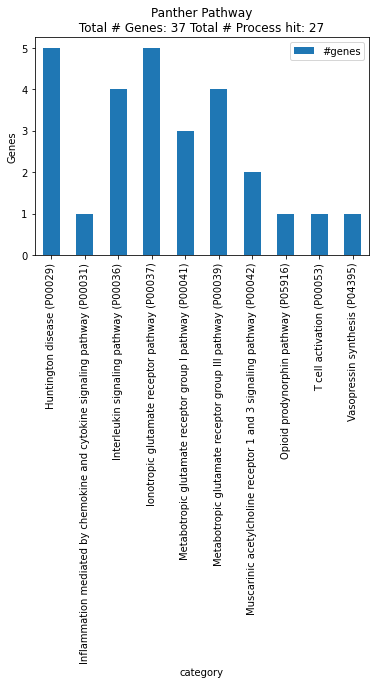

,row_index,category,#genes,#genes/(total # genes),#genes/(total # process hits)
0,1,Muscarinic acetylcholine receptor 1 and 3 sign...,2,5.3%,7.4%
1,2,Metabotropic glutamate receptor group III path...,4,10.5%,14.8%
2,3,Metabotropic glutamate receptor group I pathwa...,3,7.9%,11.1%
3,4,Ionotropic glutamate receptor pathway (P00037),5,13.2%,18.5%
4,5,Interleukin signaling pathway (P00036),4,10.5%,14.8%
5,6,Huntington disease (P00029),5,13.2%,18.5%
6,7,Inflammation mediated by chemokine and cytokin...,1,2.6%,3.7%
7,8,Opioid prodynorphin pathway (P05916),1,2.6%,3.7%
8,9,T cell activation (P00053),1,2.6%,3.7%
9,10,Vasopressin synthesis (P04395),1,2.6%,3.7%


In [99]:
# read exported Pathway txt files for two clusters from PantherDB

import matplotlib.pyplot as plt # to show figure

def plot_bar_from_pantherDB_txt(txt_file):
    # this function is used to plot bar chart from the PantherDB txt file
    chart_df= pd.read_csv(txt_file, header=None, sep = "\t") # read txt file for cluster 1
    chart_df.columns=['row_index', 'category', '#genes', '#genes/(total # genes)', '#genes/(total # process hits)'] # rename columns
    
    n_genes = int(chart_df.iloc[0]['#genes']/float(chart_df.iloc[0]['#genes/(total # genes)'][:-1]) * 100) # find gene number 
    n_hits = int(chart_df.iloc[0]['#genes']/float(chart_df.iloc[0]['#genes/(total # process hits)'][:-1]) * 100) # find total process hits
    
    # plot the bar chart
    # dataframe is sorted by category alphabetic order to mimic the presentation style of PantherDB chart
    chart_df.set_index('category')[['#genes']].sort_index().plot.bar(ylabel="Genes", title=f"Panther Pathway\n Total # Genes: {n_genes} Total # Process hit: {n_hits} ")
    
    plt.show() # display graph
    
    return chart_df # return chart table


plot_bar_from_pantherDB_txt("pantherChart_score_2_cluster_1.txt") # run this method on txt file from cluster 1 in gene score 2